In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Вначале подгружаем данные и смотрим на первоначальный их вид с помощью визуализации, для примера беру два временных ряда: стационарный и не стационарный

In [7]:
airlines_passengers = pd.read_csv('/Users/anastasiafedoracenko/Desktop/Series/international-airline-passengers.csv')
female_births = pd.read_csv('/Users/anastasiafedoracenko/Desktop/Series/daily-total-female-births-in-cal.csv')

In [8]:
all_series = {
    'International airline passengers: monthly totals in thousands': airlines_passengers['Count'],
    'Daily total female births in California': female_births['Count']
}

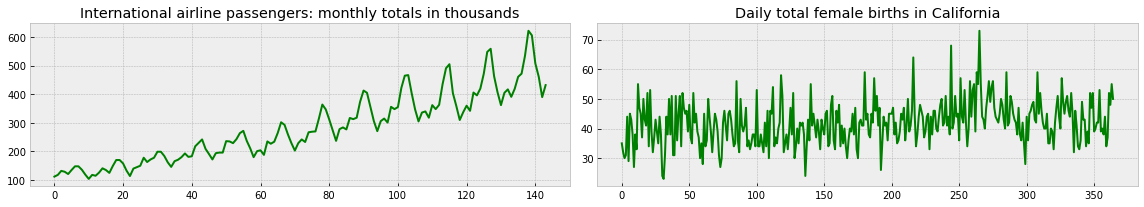

In [9]:
with plt.style.context('bmh'):
    plt.figure(figsize = (16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax = ts_ax, color = 'green')
        ts_ax.set_title(key)
        
    plt.tight_layout()

Далее из материалов с лекции выпишу нужные формулы для анализа 

Функция для подсчета скользяшего среднего

In [16]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

Функция для подсчета взвешенного скользяшего среднего

In [17]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw = True)
    return wma

Функция для подсчета экспоненциального скользяшего среднего

P.S. лектор сказал, что нужно 4 анализа, и про подсчет простого эскпоненциального скользящего среднего ничего не сказал, но думаю, что это оговорка, так что делаю и его тоже

In [18]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return pd.Series(result)

Функция для подсчета двойного экспоненциального скользяшего среднего

In [19]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return pd.Series(result)

Функция для подсчета тройного экспоненциального скользяшего среднего


In [20]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series) + n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m * trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha * (val - seasonals[i%slen]) + (1 - alpha) * (smooth + trend)
            trend = beta * (smooth - last_smooth) + (1 - beta) * trend
            seasonals[i%slen] = gamma * (val - smooth) + (1 - gamma) * seasonals[i%slen]
            result.append(smooth + trend + seasonals[i%slen])
    return result

Функции для сглаживания сезонной компоненты 

In [21]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [22]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

### Анализ временного ряда airlines_passengers


In [55]:
airlines = airlines_passengers['Count']

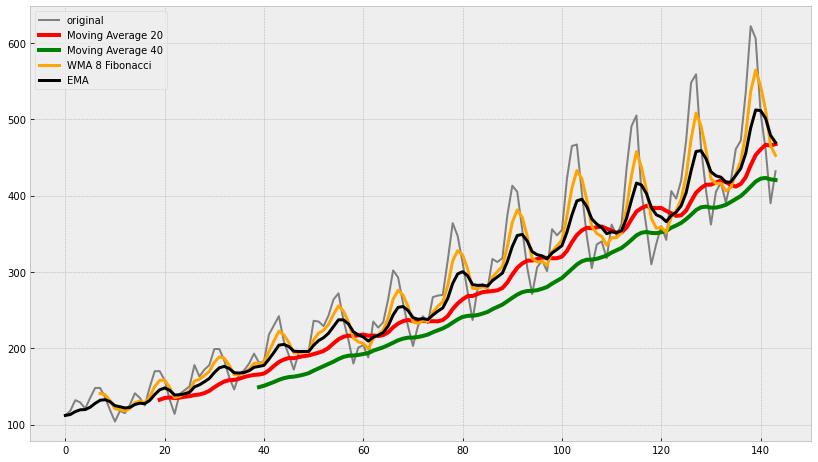

In [56]:
ma20 = moving_average(airlines, 20)
ma40 = moving_average(airlines, 40)

wma_fib = weighted_moving_average(airlines, 8, [1, 1, 2, 3, 5, 8, 13, 21])

ema = exponential_moving_average(airlines, 0.2)

with plt.style.context('bmh'):
    plt.figure(figsize = (14, 8))
    plt.plot(airlines, color = 'gray',label = 'original')
    plt.plot(ma20, color = 'red', linewidth = '4', label = 'Moving Average 20')
    plt.plot(ma40, color = 'green', linewidth = '4', label = 'Moving Average 40')
    plt.plot(wma_fib, color = 'orange', linewidth = '3', label = 'WMA 8 Fibonacci')
    plt.plot(ema, color = 'black', linewidth = '3', label = 'EMA')
    plt.legend()

In [58]:
len(airlines)

144

In [59]:
train, test, val = airlines[:87], airlines[87:100], airlines[100:]

In [60]:
opt = minimize(mse, x0 = [0,0,0], method = "L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [61]:
alpha_opt, beta_opt, alpha_opt = opt.x
opt

      fun: 515.7605016647447
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.72419548e+01,  1.13686838e-05, -0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([1.        , 0.02172259, 1.        ])

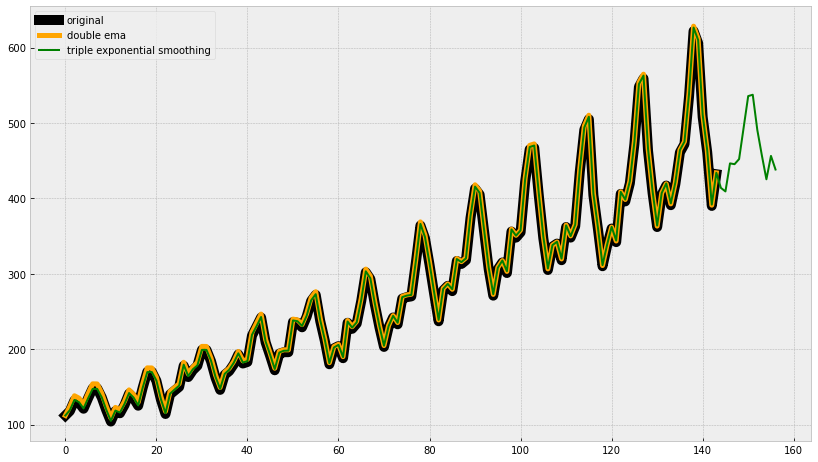

In [75]:
dbl_ema = double_ema(airlines, alpha_opt, beta_opt)
trpl_ema = triple_exponential_smoothing(airlines, 12, alpha_opt, beta_opt, alpha_opt, len(test))

with plt.style.context('bmh'):
    plt.figure(figsize = (14, 8))
    plt.plot(airlines, color = 'black', linewidth = '10', label = 'original')
    plt.plot(dbl_ema, color = 'orange', linewidth = '5', label = 'double ema')
    plt.plot(trpl_ema, color = 'green', linewidth = '2', label = 'triple exponential smoothing')
    plt.legend()

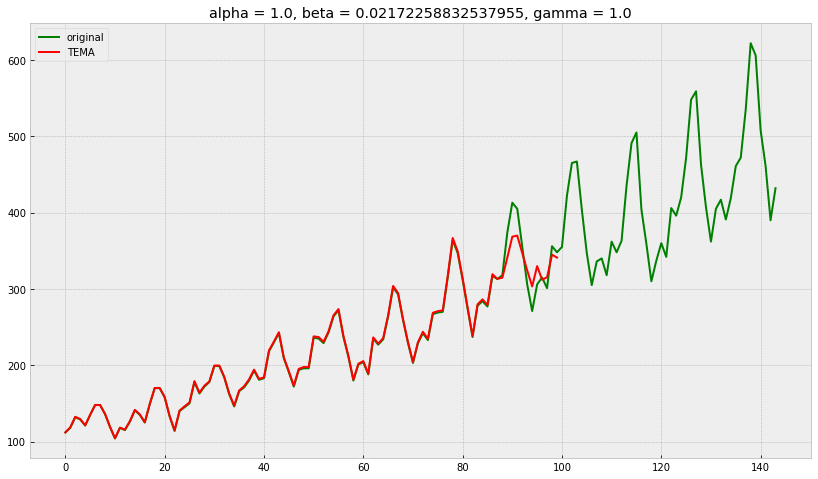

In [76]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser = train, ser_to_plot = airlines, n_preds=len(test))

### Далее анализ времеенного ряда famele_births 

In [23]:
series = female_births['Count']

Ряд изначально стационарен, тут нет сезонности и тренда, так что буду анализировать ряд на 3х моделях 

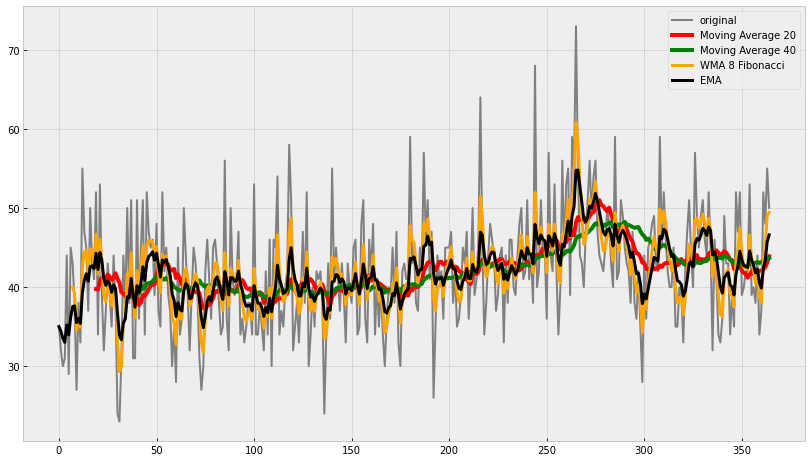

In [29]:
ma20 = moving_average(series, 20)
ma40 = moving_average(series, 40)

wma_fib = weighted_moving_average(series, 8, [1, 1, 2, 3, 5, 8, 13, 21])

ema = exponential_moving_average(series, 0.2)

with plt.style.context('bmh'):
    plt.figure(figsize = (14, 8))
    plt.plot(series, color = 'gray', label = 'original')
    plt.plot(ma20, color = 'red', linewidth = '4', label = 'Moving Average 20')
    plt.plot(ma40, color = 'green', linewidth = '4', label = 'Moving Average 40')
    plt.plot(wma_fib, color = 'orange', linewidth = '3', label = 'WMA 8 Fibonacci')
    plt.plot(ema, color = 'black', linewidth = '3', label = 'EMA')
    plt.legend()

Дальше подбираю параметры для модели Хольта-Винтерса и строб визуализацию с предсказанием

In [30]:
train, test, val = series[:220], series[220:260], series[260:365]

In [31]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [32]:
opt = minimize(mse, x0 = [0, 0, 0], method = "L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [35]:
alpha_opt, beta_opt, gamma_opt = opt.x
opt

      fun: 42.964925733024685
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -14.86952491, 1129.83602989,   -0.        ])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([1., 0., 1.])

In [39]:
def plot_tema(alpha, beta, gamma, ser = series, ser_to_plot = series, n_preds = 24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize = (14, 8))
        plt.plot(ser_to_plot, color = 'green', label = 'original')
        plt.plot(tema, color = 'red', linewidth = '2', label = 'TEMA')
        plt.title("alpha = {}, beta = {}, gamma = {}".format(alpha, beta, gamma))
        plt.legend()

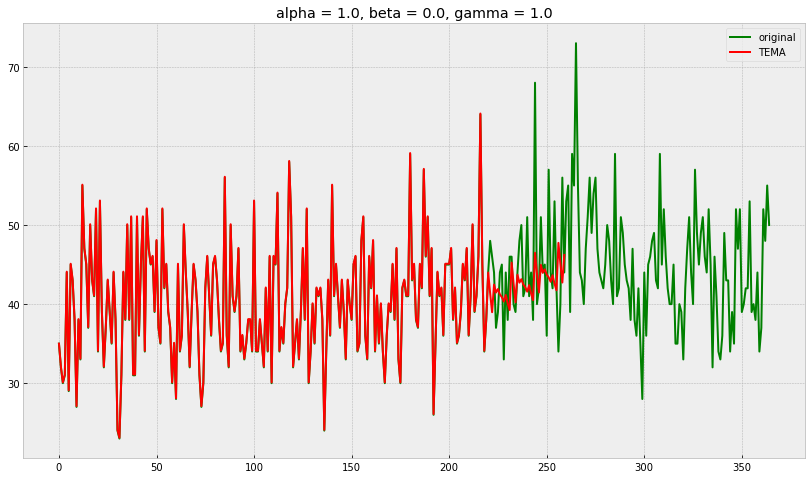

In [40]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser = train, ser_to_plot = series, n_preds = len(test))


## Оценка качества и  соображения, почему была выбрана та или иная модель.

1. При подборе параметров для модели Хольта-Винтерса получаем почти точно приболиженную модель для трэйна


2. При применении среднего скользящего, среднего скользящего взвещенного, экспоненциоального сглаживания ожидаемо получаем сглаженные репрезентации временных рядов. Чем более простой метод берем, тем более "сглаженный" результат получаем


3. При двойном и тройном эксоненциальном сглаживании не стационарного ряда получаем практически точное предсказание для трэйна